# Bag of Words Topic Classification

In [1]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# General libraries.
import re
import numpy as np
import matplotlib.pyplot as plt

# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.grid_search import GridSearchCV
from sklearn.model_selection import GridSearchCV


# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix, make_scorer, accuracy_score, f1_score
from sklearn import metrics
from sklearn.metrics import classification_report

# SK-learn library for importing the newsgroup data.
from sklearn.datasets import fetch_20newsgroups

# SK-learn libraries for feature extraction from text.
from sklearn.feature_extraction.text import *

import pandas as pd
import warnings
import nltk
import difflib
from nltk.stem.lancaster import LancasterStemmer
from nltk.stem import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import words
from sklearn import decomposition

warnings.filterwarnings('ignore')
nltk.download('wordnet')
nltk.download('words')
word_list = words.words()

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\tyu\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\tyu\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


## Getting and Splitting the data

In [2]:
categories = ['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']
newsgroups_train = fetch_20newsgroups(subset='train',
                                      remove=('headers', 'footers', 'quotes'),
                                      categories=categories)
newsgroups_test = fetch_20newsgroups(subset='test',
                                     remove=('headers', 'footers', 'quotes'),
                                     categories=categories)

num_test = len(newsgroups_test.target)
test_data, test_labels = newsgroups_test.data[num_test/2:], newsgroups_test.target[num_test/2:]
dev_data, dev_labels = newsgroups_test.data[:num_test/2], newsgroups_test.target[:num_test/2]
train_data, train_labels = newsgroups_train.data, newsgroups_train.target

print 'training label shape:', train_labels.shape
print 'test label shape:', test_labels.shape
print 'dev label shape:', dev_labels.shape
print 'labels names:', newsgroups_train.target_names

training label shape: (2034L,)
test label shape: (677L,)
dev label shape: (676L,)
labels names: ['alt.atheism', 'comp.graphics', 'sci.space', 'talk.religion.misc']


## Viewing the data

In [3]:
for x in range(0,5):
    print """
    
    Training data {0}:
    
    {1}
    
    Training label {0}:
    
    {2}
    
    """.format(str(x+1),train_data[x], train_labels[x])


    
    Training data 1:
    
    Hi,

I've noticed that if you only save a model (with all your mapping planes
positioned carefully) to a .3DS file that when you reload it after restarting
3DS, they are given a default position and orientation.  But if you save
to a .PRJ file their positions/orientation are preserved.  Does anyone
know why this information is not stored in the .3DS file?  Nothing is
explicitly said in the manual about saving texture rules in the .PRJ file. 
I'd like to be able to read the texture rule information, does anyone have 
the format for the .PRJ file?

Is the .CEL file format available from somewhere?

Rych
    
    Training label 1:
    
    1
    
    

    
    Training data 2:
    
    

Seems to be, barring evidence to the contrary, that Koresh was simply
another deranged fanatic who thought it neccessary to take a whole bunch of
folks with him, children and all, to satisfy his delusional mania. Jim
Jones, circa 1993.


Nope - fruitcakes like Koresh h

## Simple EDA

Here I am pritting out some basic properties of the data including:
- The size of the vocabulary
- The average number of non-zero features
- The fraction of the entries in the matrix are non-zero
- The 0th and last feature strings
- The average number of non-zero features per example
- The bigram and trigram vocabulary size
- Size of vocabulary does this yield after pruning < 10 words
- Theraction of the words in the dev data that are missing from the vocabulary

In [4]:
vectorizer = CountVectorizer()

X = vectorizer.fit_transform(train_data)
print "The size of the vocabulary is", len(vectorizer.get_feature_names())
print "The average number of non-zero features per example: ", X.nnz/X.shape[0]
print "The percent (converted from the fraction) of the entries that are non-zero: ", round(float(X.nnz)/(X.toarray().size)*100,2), '%'

sorted_features = sorted(vectorizer.get_feature_names())

print "The 0th feature string is", sorted_features[0]
print "The last feature string is", sorted_features[len(vectorizer.get_feature_names())-1]

vocab = ["atheism", "graphics", "space", "religion"]
vectorizer = CountVectorizer(vocabulary = vocab)

X = vectorizer.fit_transform(train_data)
print "The total number of non-zero elements are: ", X.nnz
print "The average number of non-zero features per example: ", float(X.nnz)/X.shape[0]

vectorizer = CountVectorizer(ngram_range = (2,2), analyzer='word')
X = vectorizer.fit_transform(train_data)
print 'The number of bigrams words are: ', len(vectorizer.get_feature_names())

vectorizer = CountVectorizer(ngram_range = (3,3), analyzer='word')
X = vectorizer.fit_transform(train_data)
print 'The number of trigrams words are: ', len(vectorizer.get_feature_names())

vectorizer = CountVectorizer(ngram_range = (2,2), analyzer='char')
X = vectorizer.fit_transform(train_data)
print 'The number of bigrams characters are: ', len(vectorizer.get_feature_names())

vectorizer = CountVectorizer(ngram_range = (3,3), analyzer='char')
X = vectorizer.fit_transform(train_data)
print 'The number of trigrams characters are: ', len(vectorizer.get_feature_names())

setting = 10
vectorizer = CountVectorizer(min_df = setting)
X = vectorizer.fit_transform(train_data)
print 'The number of vocab using min_df:', setting ,'are: ', len(vectorizer.get_feature_names())

def get_vocab_size(data):
    vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(data)
    
    return vectorizer.get_feature_names()

in_dev_notin_train = np.setdiff1d(get_vocab_size(dev_data),get_vocab_size(train_data))
per_miss_in_dev = round(1.0*len(in_dev_notin_train)/len(get_vocab_size(dev_data))*100),'%'

print 'The percent of words in dev data missing from the vocab from the training data is', per_miss_in_dev


Part A

The size of the vocabulary is 26879
The average number of non-zero features per example:  96
The percent (converted from the fraction) of the entries that are non-zero:  0.36 %

Part B

The 0th feature string is 00
The last feature string is zyxel

Part C

The total number of non-zero elements are:  546
The average number of non-zero features per example:  0.268436578171

Part D

The number of bigrams words are:  194891
The number of trigrams words are:  315692
The number of bigrams characters are:  3291
The number of trigrams characters are:  32187

Part E

The number of vocab using min_df: 10 are:  3064

Part F

The percent of words in dev data missing from the vocab from the training data is (25.0, '%')


### Trying some models

Here I tried some quick hyperparameter tuning for knn, multinomial nb, and logistic regression and print our the performance metrics. 

In [5]:
def vectorize_data2df(train, dev, gram = (1,1), preprocessor = None, show_features = 0):
    
    if gram == (1,1):
        print 'Normal vectorizer chosen'
    else:
        print 'Anagram vectorizer chosen:', gram
    
    vectorizer = CountVectorizer(ngram_range = gram, analyzer='word')
        
    if preprocessor != None:
        print 'Adding preprocessing function.'
        vectorizer.set_params(preprocessor=preprocessor)        
        
    train_matrix = vectorizer.fit_transform(train).todense()
    dev_matrix = vectorizer.transform(dev).todense()
    
    columns = vectorizer.get_feature_names()
    
    df_train = pd.DataFrame(data=train_matrix, columns=columns)
    df_dev = pd.DataFrame(data=dev_matrix, columns=columns)
    
    if show_features != 0:
        print columns
    
    print "Data prepared."
    
    return df_train, df_dev

In [8]:
def find_best_parameter(name, c,p):
    
    #scorer = make_scorer(accuracy_score)
    scorer = make_scorer(f1_score, average='weighted')

    grid_obj = GridSearchCV(c, p, scoring=scorer)
    grid_obj = grid_obj.fit(train_data_df, train_labels)
    
    classifier = grid_obj.best_estimator_
    classifier.fit(train_data_df, train_labels)
    predictions = classifier.predict(dev_data_df)

    print name,'\n'
    print 'Optimal paramter:', grid_obj.best_params_, '\n'
    print 'Accuracy score:', accuracy_score(dev_labels, predictions), '\n'
    print 'F1 score:', f1_score(dev_labels, predictions, average='weighted'), '\n'
    
    best_param = grid_obj.best_params_[grid_obj.best_params_.keys()[0]]
    
    print 'Saving best parameter...',best_param, '\n'
    return best_param


train_data_df, dev_data_df = vectorize_data2df(train_data,dev_data,(1,1))

mnb_bestp = find_best_parameter('Multinomial Naive Bayse', MultinomialNB(), {'alpha': [0,0.01,0.001]})
log_bestp = find_best_parameter('Logistic Regression', LogisticRegression(), {'C': np.arange(0.01,0.25,0.01)})
knn_bestp = find_best_parameter('K Nearest Neighbors', KNeighborsClassifier(), {'n_neighbors': [97]})

Multinomial Naive Bayse 

Optimal paramter: {'alpha': 0.01} 

Accuracy score: 0.7795857988165681 

F1 score: 0.7751663218544357 

Saving best parameter... 0.01 

Logistic Regression 

Optimal paramter: {'C': 0.18000000000000002} 

Accuracy score: 0.7144970414201184 

F1 score: 0.7075749110117433 

Saving best parameter... 0.18000000000000002 

K Nearest Neighbors 

Optimal paramter: {'n_neighbors': 97} 

Accuracy score: 0.47928994082840237 

F1 score: 0.46655013143953317 

Saving best parameter... 97 



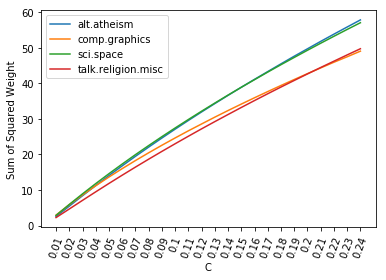

      alt.atheism  comp.graphics  sci.space  talk.religion.misc
0.01     2.541473       2.939709   2.862469            2.249805
0.02     5.470644       5.876188   5.940800            4.668306
0.03     8.398836       8.618777   8.926027            7.097120
0.04    11.268958      11.206100  11.810930            9.497170
0.05    14.073354      13.670579  14.604472           11.860673
0.06    16.808967      16.026400  17.314791           14.178626
0.07    19.479953      18.294667  19.957428           16.454128
0.08    22.083626      20.481777  22.514227           18.683922
0.09    24.633662      22.602634  25.020023           20.874869
0.1     27.129775      24.655334  27.459466           23.024233
0.11    29.576239      26.659901  29.844322           25.136564
0.12    31.976483      28.592543  32.181850           27.220880
0.13    34.327876      30.510160  34.469254           29.251986
0.14    36.644318      32.371745  36.716731           31.252154
0.15    38.919134      34.184769  38.908

In [9]:
# Finding the sum of the squared weight values for each class for 
# each setting of the C parameter for logistic regression

cls = LogisticRegression()
parameters = np.arange(0.01,0.25,0.01)

all_val_df = pd.DataFrame()

for parameter in parameters:
    cls.set_params(C = parameter)
    cls.fit(train_data_df, train_labels)
    
    coefficients = (pd.DataFrame(cls.coef_))**2
    all_val_df[parameter] = coefficients.sum(axis=1)
    
all_val_df = all_val_df.T
all_val_df = all_val_df.rename(index=str, columns={i:v for i,v in enumerate(newsgroups_train.target_names)})

ax = all_val_df.plot()
ax.set(xlabel="C", ylabel="Sum of Squared Weight")
plt.xticks(np.arange(len(all_val_df.index)), all_val_df.index, rotation=70)
plt.show()

print all_val_df

### Finding the top weighted words/bigrams for each class

In [10]:
cls = LogisticRegression(C = log_bestp)
cls.fit(train_data_df, train_labels)

coefficients = cls.coef_
df_coef = pd.DataFrame(coefficients, columns = train_data_df.columns.values)

best_cols = []

for i,thelist in enumerate(coefficients):
    print newsgroups_train.target_names[i]
    
    top_list = sorted(zip(train_data_df.columns.values, cls.coef_[i]),key=lambda tup: tup[1])[-5:]
    print top_list,'\n'
    
    for (name, value) in top_list:
        best_cols.append(name)
        
df_coef = df_coef[best_cols].T
df_coef = df_coef.rename(index=str, columns={i:v for i,v in enumerate(newsgroups_train.target_names)})

print df_coef

alt.atheism
[(u'islam', 0.5121043477615559), (u'atheists', 0.5828907106939208), (u'religion', 0.5959915607989166), (u'atheism', 0.5965268297095336), (u'bobby', 0.5970158432272148)] 

comp.graphics
[(u'computer', 0.660434568308712), (u'3d', 0.684595250809784), (u'file', 0.7819793535620624), (u'image', 0.8029676975621671), (u'graphics', 1.2157367157454406)] 

sci.space
[(u'spacecraft', 0.5024902802321605), (u'launch', 0.581569621863684), (u'nasa', 0.6447253806899584), (u'orbit', 0.7358292117280132), (u'space', 1.4672869418707928)] 

talk.religion.misc
[(u'order', 0.534064564567943), (u'fbi', 0.5366450550779899), (u'blood', 0.5706982208008935), (u'christians', 0.6408258201306598), (u'christian', 0.6723947059101167)] 

            alt.atheism  comp.graphics  sci.space  talk.religion.misc
islam          0.512104      -0.092704  -0.205246           -0.206956
atheists       0.582891      -0.086082  -0.195583           -0.399438
religion       0.595992      -0.368029  -0.482990           -0.01

In [11]:
train_data_df2, dev_data_df2 = vectorize_data2df(train_data,dev_data,(2,2))

Anagram vectorizer chosen: (2, 2)
Data prepared.


In [12]:
cls = LogisticRegression(C = log_bestp)
cls.fit(train_data_df2, train_labels)

coefficients = cls.coef_
df_coef = pd.DataFrame(coefficients, columns = train_data_df2.columns.values)

best_cols = []

for i,thelist in enumerate(coefficients):
    print newsgroups_train.target_names[i]
    
    top_list = sorted(zip(train_data_df2.columns.values, cls.coef_[i]),key=lambda tup: tup[1])[-5:]
    print top_list,'\n'
    
    for (name, value) in top_list:
        best_cols.append(name)
        
df_coef = df_coef[best_cols].T
df_coef = df_coef.rename(index=str, columns={i:v for i,v in enumerate(newsgroups_train.target_names)})

print df_coef

alt.atheism
[(u'are you', 0.33886739304914343), (u'is not', 0.34483923353425766), (u'in this', 0.3524820518892682), (u'claim that', 0.3844124388257842), (u'cheers kent', 0.40272102275620614)] 

comp.graphics
[(u'comp graphics', 0.5106692751744454), (u'is there', 0.531400622844133), (u'out there', 0.5659657519588308), (u'in advance', 0.6334320213442226), (u'looking for', 0.8201783029025946)] 

sci.space
[(u'it was', 0.39891986676838515), (u'and such', 0.44899188575889376), (u'sci space', 0.4549261111128839), (u'the space', 0.6457584242300268), (u'the moon', 0.6593809004799214)] 

talk.religion.misc
[(u'the word', 0.3121599267216939), (u'but he', 0.32389846098503117), (u'with you', 0.3311586555264025), (u'the fbi', 0.40292573889216404), (u'cheers kent', 0.4105155201815146)] 

               alt.atheism  comp.graphics  sci.space  talk.religion.misc
are you           0.338867      -0.179555  -0.084510           -0.199806
is not            0.344839      -0.172796  -0.337052            0.033

## Trying a custom pre-processor

In [13]:
# Make Lowercase
def lowercase(s):
    return s.lower()

# Replace all numbers with 1
# This regex is from here: https://stackoverflow.com/questions/1043619/get-numbers-from-string-with-regex
def replace_numbers(s):
    return re.sub('\d+', 'number', s)

# Replace non-letter symbols. 
# Looking at the data, the biggest symbol seems to be "_". Therefore only replacing that one. Tried the below but it made more features somehow.
# return re.sub('[^a-zA-Z0-9 ]','',s)
def replace_non_letter(s):
    return re.sub('[_]','',s)

# Erase words beyond 5 characters
def erase_long_words(s):
    corpus = ''
    for word in s.strip().split(' '):
        word = re.sub('\b[a-zA-Z]{1,4}\b','',s)
        corpus += word + ' '
        
    return corpus

# Lemming the words
def lem_word(s):
    lem = WordNetLemmatizer()
    corpus = ''
    for word in s.strip().split(' '):
        word = lem.lemmatize(word)
    
        corpus += word + ' '
        
    return corpus

# Stemming the words
def stem_words(s):
    st = SnowballStemmer('english')
    corpus = ''
    for word in s.strip().split(' '):
        word = st.stem(word)
    
        corpus += word + ' '
        
    return corpus

# Finds the closests word in word_list and then replaces
def replace_with_closest(s):
    match = difflib.get_close_matches(s,word_list, cutoff=0.8, n=1)
    if not match:
        return s
    else:
        return match[0]

# Putting all the functions together. If commented out, that function made it worse.
def better_preprocessor(s):
    s = lowercase(s)
    s = replace_non_letter(s)
    s = replace_numbers(s)
    s = lem_word(s)
    #s = replace_with_closest(s)
    #s = stem_words(s)
    #s = erase_long_words(s)
    
    return s

# Preparing the data. 

# Make the normal data
print '\n Transforming Train Data \n'
train_data_df, dev_data_df = vectorize_data2df(train_data,dev_data,(1,1))

# Make the preprocessed data
print '\n Transforming Dev Data \n'
train_data_df_proc, dev_data_df_proc = vectorize_data2df(train_data,dev_data,(1,1),better_preprocessor, show_features=0)

print '\n Transformation Successful \n'


 Transforming Train Data 

Normal vectorizer chosen
Data prepared.

 Transforming Dev Data 

Normal vectorizer chosen
Adding preprocessing function.
Data prepared.

 Transformation Successful 



In [14]:
def doLogistic_custompre(train, dev):
    
    cls = LogisticRegression(C = log_bestp)
    cls.fit(train, train_labels)

    predictions = cls.predict(dev)
    cls_reports = classification_report(dev_labels, predictions)
    accuracy = accuracy_score(dev_labels, predictions)
    f1 = f1_score(dev_labels, predictions, average = 'weighted')

    print 'The accuracy was', accuracy
    print 'The f1 score is', f1, '\n'

print 'The normal stats are:'
doLogistic_custompre(train_data_df, dev_data_df)
print 'After processing the stats are:'
doLogistic_custompre(train_data_df_proc, dev_data_df_proc)

The normal stats are:
The accuracy was 0.7144970414201184
The f1 score is 0.7075749110117433 

After processing the stats are:
The accuracy was 0.7174556213017751
The f1 score is 0.7112445521163012 



Seems like the accuracy and f1 improved a little with the changes made. 

### Using L1 Regularization to reduce sparsity

In [15]:
# The below function is for logistic that has a parameter for setting penalty
def doLogistic_L1L2(train, dev, penalty = 'l2', C_val = log_bestp):
        
    #print 'Initial Train shape',train.shape,'Dev shape',dev.shape
    
    cls = LogisticRegression(C = C_val, penalty = penalty)
    cls.fit(train, train_labels)
    
    df = pd.DataFrame(cls.coef_, columns = train.columns.values)

    return df

# The below is to count non-zero features. 
def count_nonzero(df):
    count = 0
    
    for column in df.columns.values:
        if df[column].sum() != 0:
            count += 1
            
    df = df.loc[:, (df != 0).any(axis=0)]
            
    return count, df.columns.values

# The below is to retrain the data with the addition of adjusting the C parameter and making the graph at the end. 
def doLogistic_retrain(train,dev,penalty = 'l2', keep = None):
    
    if isinstance(keep, list):
        dev = dev[keep]
        train = train[keep]
                
    vocab_accuracy = {}
    
    cls = LogisticRegression(C = log_bestp, penalty = penalty, tol=0.01)
    cls.fit(train, train_labels)

    predictions = cls.predict(dev)
    accuracy = accuracy_score(dev_labels, predictions)
    
    return accuracy 


# Keep this random seed here to make comparison easier.
np.random.seed(0)

In [16]:
# Make the normal data
print '\n Transforming Train Data \n'
train_data_df, dev_data_df = vectorize_data2df(train_data,dev_data,(1,1))

# Executing the analysis and making the graph. 
coef_l2 = doLogistic_L1L2(train_data_df, dev_data_df, 'l2', log_bestp)
coef_l2_count, L2_col_names  = count_nonzero(coef_l2)

coef_l1 = doLogistic_L1L2(train_data_df, dev_data_df, 'l1', log_bestp)
coef_l1_count, L1_col_names = count_nonzero(coef_l1)

print 'The number of features that have non-zero weights for L2 is', coef_l2_count, 'whereas for L1 it is', coef_l1_count
print 'The retrained accuracy is', doLogistic_retrain(train_data_df, dev_data_df, keep = L1_col_names.tolist())


 Transforming Train Data 

Normal vectorizer chosen
Data prepared.
The number of features that have non-zero weights for L2 is 26879 whereas for L1 it is 337
The retrained accuracy is 0.6760355029585798


## Using TFIDF instead of Count Vectorizer

In [18]:
def vectorize_tfidf_data2df(train, dev, gram, preprocessor = None, stop_words = None, sublinear_tf = None, min_df = None, show_features = 0):
    
    if gram == (1,1):
        print 'Normal vectorizer chosen'
    else:
        print 'Anagram vectorizer chosen:', gram
    
    vectorizer = TfidfVectorizer(ngram_range = gram, analyzer ="word")
        
    if preprocessor != None:
        print 'Adding preprocessing function.'
        vectorizer.set_params(preprocessor=preprocessor)
    
    if stop_words != None:
        print 'Adding stop_words function.'
        vectorizer.set_params(stop_words=stop_words)   
        
    if sublinear_tf != None:
        print 'Adding sublinear_df function.'
        vectorizer.set_params(sublinear_tf=sublinear_tf)   
        
    if min_df != None:
        print 'Adding min_df function.'
        vectorizer.set_params(min_df=min_df)   
            
    train_matrix = vectorizer.fit_transform(train).todense()
    dev_matrix = vectorizer.transform(dev).todense()
    
    columns = vectorizer.get_feature_names()
    
    if show_features == 1:
        print columns
    else:
        pass
    
    df_train = pd.DataFrame(data=train_matrix, columns=columns)
    df_dev = pd.DataFrame(data=dev_matrix, columns=columns)
    
    return df_train, df_dev

# Defining the logistic function plus the outputs required. 

def doLogistic_tfidf(train, dev):
    
    cls = LogisticRegression(C = 100)
    cls.fit(train, train_labels)
    
    pred_prob = pd.DataFrame(cls.predict_proba(dev))
    pred_prob['max'] = pred_prob.max(axis=1)
    pred_prob['pred'] = cls.predict(dev)
    pred_prob['labels'] = dev_labels
    pred_prob['label_prob'] = pred_prob.lookup(pred_prob.index, pred_prob.labels)
    pred_prob['R ratio'] = pred_prob['max']/pred_prob['label_prob']

    pred_prob = pred_prob.sort_values(by=['R ratio'], ascending=False)
    
    predictions = cls.predict(dev)
    accuracy = accuracy_score(dev_labels, predictions)
    
    print 'The accuracy was', accuracy, '\n'

    for i,(v,l,p) in enumerate(zip(pred_prob.head(5).index,pred_prob['labels'].head(5),pred_prob['pred'].head(5))):
        print '\n#############################\nExample of Poorly Predicted Document', i+1,'Pred:',newsgroups_train.target_names[p],'True:',newsgroups_train.target_names[l], '\n#############################\n'
        print dev_data[v]
    

# Running the above functions. 
    
train_data_df, dev_data_df = vectorize_tfidf_data2df(train_data, dev_data, (1,1))

doLogistic_tfidf(train_data_df, dev_data_df)


Normal vectorizer chosen
The accuracy was 0.7633136094674556 


#############################
Example of Poorly Predicted Document 1 Pred: comp.graphics True: talk.religion.misc 
#############################

I am pleased to announce that a *revised version* of _The Easy-to-Read Book
of Mormon_ (former title: _Mormon's Book_) by Lynn Matthews Anderson is now
available through anonymous ftp (see information below). In addition to the
change in title, the revised ETR BOM has been shortened by several pages
(eliminating many extraneous "that's" and "of's"), and many (minor) errors
have been corrected. This release includes a simplified Joseph Smith Story,
testimonies of the three and eight witnesses, and a "Words-to-Know"
glossary.

As with the previous announcement, readers are reminded that this is a
not-for-profit endeavor. This is a copyrighted work, but people are welcome
to make *verbatim* copies for personal use. People can recuperate the
actual costs of printing (paper, copy cent

Compared with the original method of using CountVectorizer to the point here using TfidfVectorizer, we have essentially improved from approximately 0.71 to approximately 0.76 for both accuracy and f1 score. 